In [1]:
!pip install -U d2l torch numpy

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     --------------------------------- ------ 51.2/61.0 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 61.0/61.0 kB 1.1 MB/s eta 0:00:00


In [76]:
import os
import datetime
from shutil import copyfile
import sys
import math 
import traci
import numpy as np
import random
import timeit

from generator import TrafficGenerator
from memory import Memory     ## Prority Experience Memory 
from visualization import Visualization
from utils import import_train_configuration,set_sumo, set_train_path,get_model_path

import warnings
warnings.filterwarnings('ignore')

In [77]:
from d2l import torch as d2l  # Transformer block 
import torch 
import torch.nn as nn
import torch.autograd as autograd 
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Your Hyperparameter Setting 

In [157]:
# [simulation]
gui = True
total_episodes = 10 # total number of training episodes
max_steps = 3600 # maximum duration (in seconds) for each simulation episode
n_cars_generated = 1000
green_duration = 7
yellow_duration = 4

# [model]
num_layers = 4 # number of hidden layers
width_layers = 800 # number of neurons in each hidden layer
batch_size = 64
learning_rate = 0.0001
training_epochs = 512
update_epochs = 10
num_atoms = 51
Vmin = -10 # minimum possible value for the reward (normalization)
Vmax = 10 # maximum possible value for the reward (normalization)

# [memory]
memory_size_min = 1000 # Minimum size of replay memory
memory_size_max = 50000 # Maximum size of playback memory

# [agent]
num_states = 1400 
num_actions = 4  # number of features representing the traffic state (e.g., vehicle count, waiting time).
# Number of actions (changing light color) is 4. Maybe it's because there are 4 light for 4 roads 
# or 4 actions in a light in a road: both red, both green, green turns right - red turns left, vice versa)
gamma = 0.9 # discount factor used for calculating future rewards

# [dir] 
model_to_test = 1   # load model

## Your Neural Network Architecture

In [158]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(Variable(self.weight_epsilon))
            bias   = self.bias_mu   + self.bias_sigma.mul(Variable(self.bias_epsilon))
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if torch.cuda.is_available() else autograd.Variable(*args, **kwargs)

In [159]:
## Categorical & Dueling DQN 
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers,num_atoms):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_atoms = num_atoms
        self.support = torch.linspace(Vmin, Vmax, num_atoms).to(device) 
        
        self.conv1 = nn.Conv2d(3, 16, (1,3), (1,2), padding=(0,1))
        # self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(16, 32, (2,3), (2,2), padding=(0,1))
        self.linear_c = nn.Linear(32*7*25, 4096)
        self.linear_p = nn.Linear(4,10) 
        self.linear1 = nn.Linear(4096, 2048)
        self.linear2 = NoisyLinear(2068, 1024)   
        self.linear3 = NoisyLinear(2068, 1024)
        self.linear_A = NoisyLinear(1024, self.output_size*self.num_atoms)
        self.linear_V = NoisyLinear(1024, 1*self.num_atoms)
    
    def forward(self, s,a,b):
        dist = self.dist(s,a,b)
        q = torch.sum(dist*self.support, dim=2)
        return q
    
    def dist(self, s,a,b):
        x = F.relu(self.conv2(F.relu(self.conv1(s))))
        x = x.view(-1, 32*7*25)
        x = F.relu(self.linear1(F.relu(self.linear_c(x)))) 
        a = torch.tensor(a,dtype=torch.float).view(-1,4)
        b = torch.tensor(b,dtype=torch.float).view(-1,4)
        a = F.relu(self.linear_p(a)).view(-1,10)
        b = F.relu(self.linear_p(b)).view(-1,10) 
        x = torch.cat([x,a,b],dim=1).view(-1,2068)
        V = self.linear_V(F.relu(self.linear2(x)))
        A = self.linear_A(F.relu(self.linear3(x)))
        V = V.view(-1,1,self.num_atoms)
        A = A.view(-1,self.output_size,self.num_atoms)
        q = V + A - A.mean(dim=1, keepdim=True)
        
        dist = F.softmax(q,dim=-1)
        dist = dist.clamp(min=1e-3) # for avoiding nans 
        return dist
    
    def reset_noise(self):
        self.linear2.reset_noise()
        self.linear3.reset_noise()
        self.linear_A.reset_noise()
        self.linear_V.reset_noise()
        
    # def feature_size(self):
        # return self.conv2(self.conv1(torch.zeros(1, *self.input_size))).view(1, -1).size(1)

# DQN Framework --> Rainbow
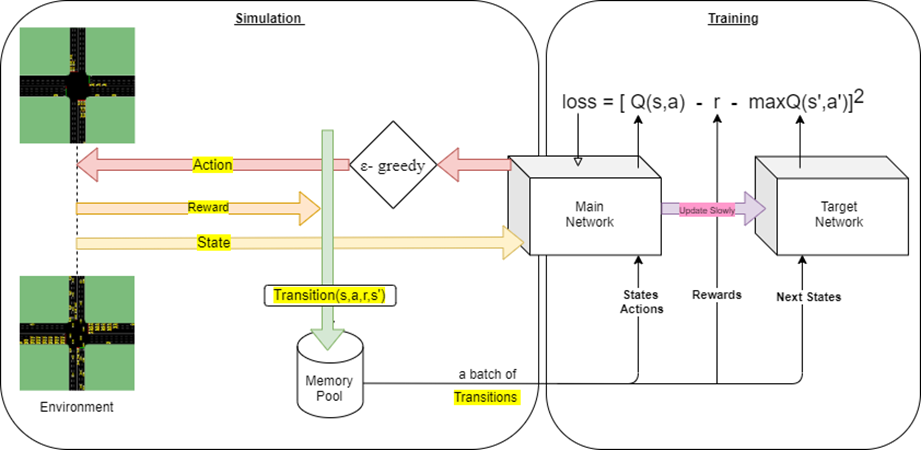


## 3-Step TD Learning
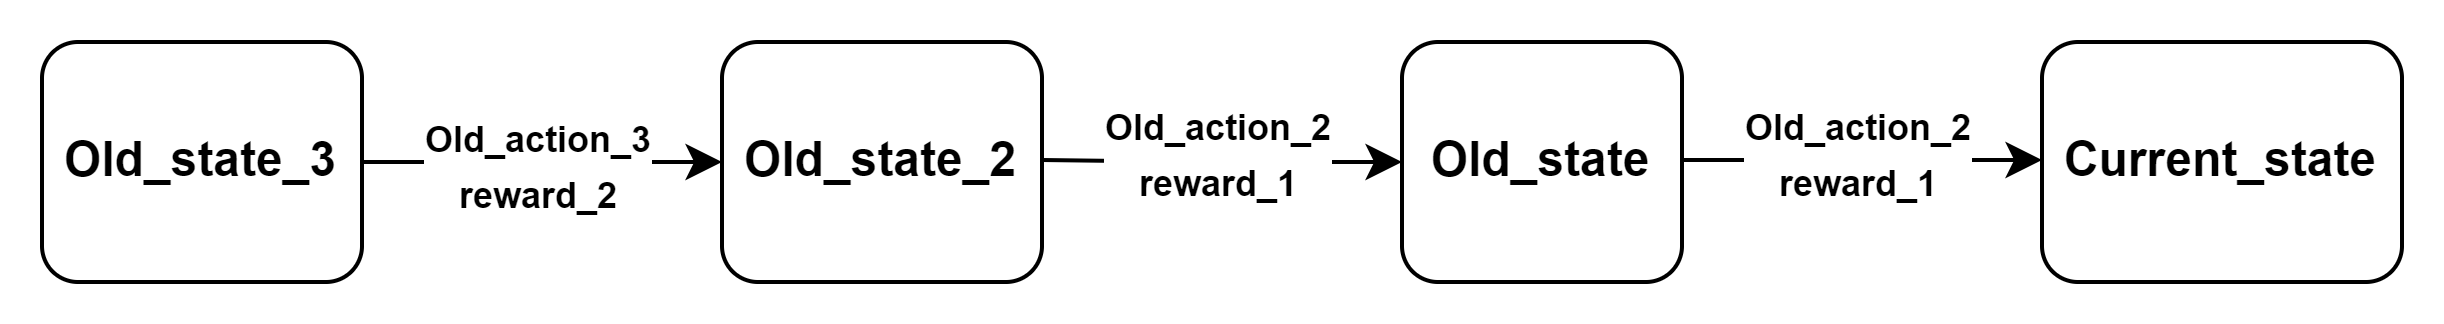

- Paper link: 

## Phase Setting based on Environment

In [160]:
# phase codes based on SUMO environment.net.xml 
PHASE_NS_GREEN = 0  # action 0 for Variable Order
PHASE_NS_YELLOW = 1
PHASE_NSL_GREEN = 2  # action 1 for Variable Order
PHASE_NSL_YELLOW = 3
PHASE_EW_GREEN = 4  # action 2 for Variable Order
PHASE_EW_YELLOW = 5
PHASE_EWL_GREEN = 6  # action 3 for Variable Order
PHASE_EWL_YELLOW = 7

## Your State Representation

In [161]:
def _get_state():
    """
    Retrieve the state of the intersection from sumo, in the form of cell occupancy
    """
    #state = np.zeros((56))        ## Vector 
    state = np.zeros((3,14,100))   ## DTSE 
    
    lane = ["N2TL_0","N2TL_1","N2TL_2","E2TL_0","E2TL_1","E2TL_2","E2TL_3","S2TL_0","S2TL_1","S2TL_2","W2TL_0","W2TL_1","W2TL_2","W2TL_3"]
    car_list = traci.vehicle.getIDList()
    lane_group = 0

    for car_id in car_list:
        lane_pos = traci.vehicle.getLanePosition(car_id)
        car_speed = traci.vehicle.getSpeed(car_id)
        lane_id = traci.vehicle.getLaneID(car_id)
        # inversion of lane pos, so if the car is close to the traffic light -> lane_pos = 0 --- 750 = max len of a road
        lane_pos = 750 - lane_pos
        
        # distance in meters from the traffic light -> mapping into cells
        lane_cell = int(lane_pos/7.5)

        for i in range(len(lane)):
            if lane_id == lane[i]:
                lane_group = i

        state[0][lane_group][lane_cell] = 1
        state[1][lane_group][lane_cell] = car_speed
        state[2][lane_group][lane_cell] = traci.vehicle.getAccumulatedWaitingTime(car_id)

        #if lane_cell <= 10: 
        #    state[lane_group] += 1
        #state[lane_group+14] += 1
        #state[lane_group+28] += car_speed
        #state[lane_group+42] += traci.vehicle.getAccumulatedWaitingTime(car_id)
        
    return state.tolist()

## Your Action Definition 

# 1. Simulation Part 

In [162]:
class Simulation:
    def __init__(self, Model, Memory, TrafficGen, sumo_cmd, gamma, max_steps, green_duration, yellow_duration, num_states, num_actions):
        self._model = Model
        self._Model_A = Model.critic
        self._Model_B = Model.critic_target
        self._Memory = Memory
        self._TrafficGen = TrafficGen
        self._gamma = gamma
        self._step = 0
        self._sumo_cmd = sumo_cmd
        self._max_steps = max_steps 
        self._green_duration = green_duration
        self._yellow_duration = yellow_duration
        self._num_states = num_states
        self._num_actions = num_actions
        self._reward_store = []
        self._speed_store = []
        self._cumulative_wait_store = []
        self._avg_queue_length_store = []

    def run(self, episode, epsilon):
        """
        Runs an episode of simulation, then starts a training session
        """
        self.training = False
        start_time = timeit.default_timer()

        # first, generate the route file for this simulation and set up sumo
        self._TrafficGen.generate_routefile(seed=episode)
        traci.start(self._sumo_cmd)
        print("Simulating...")

        # inits
        self._step = 0
        self._waiting_times = {}
        self._sum_neg_reward = 0
        self._sum_queue_length = 0
        self._sum_waiting_time = 0
        self._sum_speed = 0
        old_total_wait = 0
        old_action = 0
        reward = 0
        re = 0
        current_phase = 0
        self.reward = 0
        duration = [0,0,0,0]
        old_duration = [0,0,0,0]
        old_duration_2 = [0,0,0,0]
        old_duration_3 = [0,0,0,0]
        old_action_2 = 0
        old_action_3 = 0
        reward_1 = 0
        reward_2 = 0
        x = [0,0,0,0]
        x_1 = [0,0,0,0]
        x_2 = [0,0,0,0]
        x_3 = [0,0,0,0]
        
        self._simulate(50)  ## Warm Environment
        old_state = _get_state()
        old_state_2 = _get_state()
        old_state_3 = _get_state()

        while self._step < self._max_steps:
            
            # get current state of the intersection
            current_state = _get_state()

            # calculate reward of previous action: 
            # waiting time = seconds waited by a car since the spawn in the environment, cumulated for every car in incoming lanes
            current_total_wait = self._collect_waiting_times()    
            
            ## Your Reward Function 
            reward = - current_total_wait
            
            ## (change in cumulative waiting time between actions) is not suitable for Multi-step TD learning 
            # reward = old_total_wait - current_total_wait           
    
            current_phase = int(traci.trafficlight.getPhase("TL")/2)
            phase = current_phase - 1
            if phase == -1:
                phase = 3
                
            action = self._choose_action(current_state, epsilon,current_phase,duration) # phase, epsilon) 
            
            # print(phase, old_action, old_duration, duration)
            # saving the data into the memory
            if self._step != 0:
                x = [0,0,0,0]
                y = [0,0,0,0]
                x[old_action] = 1
                y[action] = 1         
                
                if self._step < self._max_steps - self._green_duration - self._yellow_duration:
                    TD = self._model.get_TD(old_state_3,old_action_3,reward_2,reward_1,reward,current_state,0,x_3,y,old_duration_3,duration).squeeze(0).detach().tolist()
                    self._Memory.add_sample(TD, (old_state_3,old_action_3,reward_2,reward_1,reward,current_state,0,x_3,y,old_duration_3,duration))
                else:
                    TD = self._model.get_TD(old_state_3,old_action_3,reward_2,reward_1,reward,current_state,1,x_3,y,old_duration_3,duration).squeeze(0).detach().tolist()
                    self._Memory.add_sample(TD, (old_state_3,old_action_3,reward_2,reward_1,reward,current_state,1,x_3,y,old_duration_3,duration))

            # if the chosen phase is different from the last phase, activate the yellow phase
            if self._step != 0 and old_action != action:# and i == 0:
                self._set_yellow_phase(current_phase)
                self._simulate(self._yellow_duration)
                duration[action] = self._green_duration
            else: 
                duration[action] += 7
                
            self._set_green_phase(action)
            self._simulate(self._green_duration)
            # print("current phase:",current_phase,"green:",a)

            # saving variables for later & accumulate reward
            old_state_3 = old_state_2
            old_state_2 = old_state
            old_state = current_state
            old_action_3 = old_action_2
            old_action_2 = old_action
            old_action = action
            x_3 = x_2
            x_2 = x_1
            x_1 = x
            old_duration_3 = old_duration_2
            old_duration_2 = old_duration
            old_duration = duration
            old_total_wait = current_total_wait
            reward_2 = reward_1
            reward_1 = reward

            # saving only the meaningful reward to better see if the agent is behaving correctly
            # if reward < 0:
            self._sum_neg_reward += reward
            re += 1
            self.reward = self._sum_neg_reward/re
                
        print("Total Queue:",self._sum_queue_length, "  ", "Average Reward:", self.reward, " ", "Average Speed:",self._sum_speed/self._max_steps)

        self._save_episode_stats()
        print("Total Negative Reward:", self._sum_neg_reward, "- Epsilon:", round(epsilon, 2))
        traci.close()
        simulation_time = round(timeit.default_timer() - start_time, 1)

        return simulation_time


    def _simulate(self, steps_todo):
        """
        Execute steps in sumo while gathering statistics
        """
        if (self._step + steps_todo) >= self._max_steps:  # do not do more steps than the maximum allowed number of steps
            steps_todo = self._max_steps - self._step

        while steps_todo > 0:
            traci.simulationStep()  # simulate 1 step in sumo
            self._step += 1 # update the step counter
            steps_todo -= 1
            queue_length = self._get_queue_length()
            self._sum_queue_length += queue_length
            self._sum_waiting_time += queue_length # 1 step while wating in queue means 1 second waited, for each car, therefore queue_lenght == waited_seconds
            speed = self._get_speed()
            self._sum_speed += speed
        
    def _collect_waiting_times(self):            # For reward 
        """
        Retrieve the waiting time of every car in the incoming roads
        """
        incoming_roads = ["E2TL", "N2TL", "W2TL", "S2TL"]
        car_list = traci.vehicle.getIDList()
        self._waiting_times = {}
        for car_id in car_list:
            wait_time = traci.vehicle.getAccumulatedWaitingTime(car_id)
            road_id = traci.vehicle.getRoadID(car_id)  # get the road id where the car is located
            if road_id in incoming_roads:  # consider only the waiting times of cars in incoming roads
                self._waiting_times[car_id] = wait_time 
            else:
                if car_id in self._waiting_times: # a car that was tracked has cleared the intersection
                    del self._waiting_times[car_id] 
                
        if len(self._waiting_times) == 0: 
            total_waiting_time = 0
        else: 
            total_waiting_time = sum(self._waiting_times.values())/len(self._waiting_times)
        return total_waiting_time 

    def _choose_action(self, state, epsilon,phase,old_duration): #phase, epsilon):
        """
        Decide wheter to perform an explorative or exploitative action, according to an epsilon-greedy policy
        """
        if random.random() < epsilon:
            return random.randint(0, self._num_actions - 1) # random action
        else:
            x = [0,0,0,0]
            x[phase] = 1
            return torch.argmax(self._model.predict(state,x,old_duration))#,phase)) # the best action given the current state

    def _set_yellow_phase(self, old_action):
        """
        Activate the correct yellow light combination in sumo
        """
        yellow_phase_code = old_action * 2 + 1 # obtain the yellow phase code, based on the old action (ref on environment.net.xml)
        traci.trafficlight.setPhase("TL", yellow_phase_code)

    def _set_green_phase(self, action_number):   ## For Variable Order Method 
        """
        Activate the correct green light combination in sumo
        """
        if action_number == 0:
            traci.trafficlight.setPhase("TL", PHASE_NS_GREEN)
        elif action_number == 1:
            traci.trafficlight.setPhase("TL", PHASE_NSL_GREEN)
        elif action_number == 2:
            traci.trafficlight.setPhase("TL", PHASE_EW_GREEN)
        elif action_number == 3:
            traci.trafficlight.setPhase("TL", PHASE_EWL_GREEN)

    def _get_green(self,current_phase):       ## For Finetuning Method 
        if current_phase == 0:
            green = Duration_NS
        elif current_phase == 1:
            green = Duration_NSL
        elif current_phase == 2:
            green = Duration_EW
        else: 
            green = Duration_EWL
        return green

    def _get_queue_length(self):          # For evaluation 
        """
        Retrieve the number of cars with speed = 0 in every incoming lane
        """
        halt_N = traci.edge.getLastStepHaltingNumber("N2TL")
        halt_S = traci.edge.getLastStepHaltingNumber("S2TL")
        halt_E = traci.edge.getLastStepHaltingNumber("E2TL")
        halt_W = traci.edge.getLastStepHaltingNumber("W2TL")
        queue_length = halt_N + halt_S + halt_E + halt_W
        return queue_length
    
    def _get_speed(self):                  # For evaluation 
        total_speed = 0
        car_list = traci.vehicle.getIDList()
        for car_id in car_list:
            car_speed = traci.vehicle.getSpeed(car_id)
            total_speed +=car_speed
        if len(car_list) == 0: 
            s = 0
        else: 
            s = total_speed/len(car_list)
        return s
            
    def _save_episode_stats(self):
        """
        Save the stats of the episode to plot the graphs at the end of the session
        """
        self._reward_store.append(self.reward)  # how much negative reward in this episode
        self._speed_store.append(self._sum_speed / self._max_steps)
        self._cumulative_wait_store.append(self._sum_waiting_time)  # total number of seconds waited by cars in this episode
        self._avg_queue_length_store.append(self._sum_queue_length / self._max_steps)  # average number of queued cars per step, in this episode
    
    @property
    def reward_store(self):
        return self._reward_store

    @property
    def speed_store(self):
        return self._speed_store
    
    @property
    def cumulative_wait_store(self):
        return self._cumulative_wait_store

    @property
    def avg_queue_length_store(self):
        return self._avg_queue_length_store

# 2. Training Part 

In [163]:
class Training:
    def __init__(self, Model, Memory, training_epochs, update_epochs, batch_size):
        self._model = Model
        self._Model_A = Model.critic
        self._Model_B = Model.critic_target
        self._Memory = Memory
        self._loss_store = []
        self._batch_size = batch_size
        self.history = 0
        self.loss_value = 0
            
    def run(self):
        self.training = True
        print("Training...")
        start_time = timeit.default_timer()
        self.loss_value = 0
        
        for _ in range(training_epochs):
            self.experience_replay()
            self.loss_value += self.history
            if ( _ / update_epochs == 0):
                self._model._update_model()
        self.loss_value = torch.tensor(self.loss_value)
        self._save_loss()
        print("loss:",self.loss_value)
        training_time = round(timeit.default_timer() - start_time, 1)
        
        return training_time
    
    def experience_replay(self):
        """
        Retrieve a group of samples from the memory and for each of them update the learning equation, then train
        """
        #batch = self._Memory.get_samples(self._batch_size)  
        batch, idxs, is_weights = self._Memory.get_samples(self._batch_size) 
    
        if len(batch) > 0:  # if the memory is full enough
            old_states_3 = torch.tensor(([val[0] for val in batch]),dtype=torch.float).to(device) 
            old_actions_3 = torch.tensor(([val[1] for val in batch]),dtype=torch.int64).to(device)
            rewards_2 = torch.tensor(([val[2] for val in batch]),dtype=torch.float).reshape(-1,1).to(device)
            rewards_1 = torch.tensor(([val[3] for val in batch]),dtype=torch.float).reshape(-1,1).to(device)
            rewards = torch.tensor(([val[4] for val in batch]),dtype=torch.float).reshape(-1,1).to(device)
            next_states = torch.tensor(([val[5] for val in batch]),dtype=torch.float).to(device)  
            dones = torch.tensor(([val[6] for val in batch]),dtype=torch.float).reshape(-1,1).to(device)
            a = torch.tensor(([val[7] for val in batch]),dtype=torch.float).to(device)
            b = torch.tensor(([val[8] for val in batch]),dtype=torch.float).to(device)
            c = torch.tensor(([val[9] for val in batch]),dtype=torch.float).to(device)
            d = torch.tensor(([val[10] for val in batch]),dtype=torch.float).to(device)
            weights = torch.tensor((is_weights),dtype=torch.float).reshape(-1,1).to(device)
            
            ## train the NN  
            self.history,TD = self._model.critic_learn(old_states_3,old_actions_3,rewards_2,rewards_1,rewards,next_states,dones,a,b,c,d,weights) 
            self.history = self.history.to("cpu").squeeze(0).detach() 
            TD = TD.squeeze(0).detach().tolist()
            ## update the priorities 
            #TD = (self._model.get_TD(old_states_3,old_actions_3,rewards_2,rewards_1,rewards,next_states,dones,a,b,c,d)).squeeze(0).detach().tolist()
            
            for i in range(len(batch)): 
                idx = idxs[i]
                td = TD[i]   # prior_eps 
                # s0,a0,r1,s1,done = batch[i]
                # TD = self._model.get_TD(s0,a0,r1,s1,0.8,done).squeeze(0).detach().numpy()
                self._Memory.update(idx,td)
                
            self._Model_A.reset_noise()
            self._Model_B.reset_noise()
                    
    def _save_loss(self):
        self._loss_store.append(self.loss_value)

    @property
    def loss_store(self):
        return self._loss_store

## Your Deep Reinforcement Learning Algorithm

#### Categorical DQN

In [164]:
def projection_distribution(ns, r2,r1,r, dones,b,d):
    with torch.no_grad():
        batch_size  = ns.size(0)
        
        delta_z = float(Vmax - Vmin) / (num_atoms - 1)
        support = torch.linspace(Vmin, Vmax, num_atoms).to(device)

        next_action = Model.critic_target(ns,b,d).argmax(1)
        next_dist = Model.critic_target.dist(ns,b,d)
        next_dist = next_dist[range(batch_size),next_action]

        # Tz = rewards + (1 - dones) * gamma * support
        Tz = r2+gamma*r1+gamma**2*r + gamma**3 * support * (1-dones)
        Tz = Tz.clamp(min=Vmin, max=Vmax)
        b  = (Tz - Vmin) / delta_z
        l  = b.floor().long()
        u  = b.ceil().long()

        offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                        .unsqueeze(1).expand(batch_size, num_atoms).to(device)

        proj_dist = torch.zeros(next_dist.size()).to(device)    
        proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
        proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

#### 3-Step TD Learning

In [165]:
class DRL_Model():
    def __init__(self, num_layers, width, batch_size, learning_rate, input_dim, output_dim, tau,num_atoms):
        self._i_dim = (3,14,100) #input_dim
        self._o_dim = output_dim
        self.critic_lr = learning_rate
        self.tau = tau
        self.batch_size = batch_size
        
        self.critic = Critic(self._i_dim, width, self._o_dim, num_layers,num_atoms)
        self.critic_target = Critic(self._i_dim, width, self._o_dim, num_layers,num_atoms)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr = self.critic_lr)
        self._update_model()
        self.critic.to(device)
        self.critic_target.to(device)
     
    ## DQN Algorithm 
    def critic_learn(self,s3,a3,r2,r1,r,ns,done,a,b,c,d,weights):    
        # y_pred = torch.zeros(self.batch_size,1)
        # y_true =  r2+gamma*r1+gamma**2*r+gamma**3*torch.max(self.critic_target(ns,b,d)).detach()       #*(1-done) ).detach()   # y_true 
        # a3 = torch.tensor(a3,dtype=torch.int64).reshape(-1,1)
        # y_pred = torch.gather(self.critic(s3,a,c),1,a3)
        # loss_fn = nn.MSELoss()
        # loss = (weights * loss_fn(y_pred, y_true)).mean()
        
        proj_dist = projection_distribution(ns, r2,r1,r, done,b,d)
        dist = self.critic.dist(s3,a,c) 
        log_p = torch.log(dist[range(batch_size),a3]) 
        elementwise_loss = - (Variable(proj_dist) * log_p).sum(1)
        TD = elementwise_loss.detach()
        loss = torch.mean(weights * elementwise_loss) 
        
        self.critic_optim.zero_grad()
        loss.backward()
        clip_grad_norm_(self.critic.parameters(), 10.0)
        self.critic_optim.step()
        return loss,TD
    
    def get_TD(self,s3,a3,r2,r1,r,ns,done,a,b,c,d, alpha=0.6):        # for priority experience replay 
        s3 = torch.tensor(s3,dtype=torch.float).reshape(-1,3,14,100).to(device)
        ns = torch.tensor(ns,dtype=torch.float).reshape(-1,3,14,100).to(device)
        a = torch.tensor(a,dtype=torch.float).to(device)
        b = torch.tensor(b,dtype=torch.float).to(device)
        c = torch.tensor(c,dtype=torch.float).to(device)
        d = torch.tensor(d,dtype=torch.float).to(device)
        done = torch.tensor(done,dtype=torch.float).reshape(-1,1).to(device)
        a3 = torch.tensor(a3,dtype=torch.int64).reshape(-1,1).to(device)
        r2 = torch.tensor(r2,dtype=torch.float).to(device)
        r1 = torch.tensor(r1,dtype=torch.float).to(device)
        r = torch.tensor(r,dtype=torch.float).to(device)
        
        #y_true = r2+gamma*r1+gamma**2*r+gamma**3*torch.max(self.critic_target(ns,b,d))#*(1-done)   # y_true 
        #y_pred = torch.zeros(self.batch_size,1)
        #y_pred = torch.gather(self.critic(s3,a,c),1,a3)
        #TD = abs(y_true - y_pred).detach() 
        
        proj_dist = projection_distribution(ns, r2,r1,r, done,b,d)
        dist = self.critic.dist(s3,a,c)
        
        action = a3.unsqueeze(1).expand(s3.shape[0], 1, num_atoms)
        dist = dist.gather(1, action).squeeze(1)
        dist.data.clamp_(0.01, 0.99)
        log_p = dist.log() 
        #log_p = torch.log(torch.gather(self.critic.dist(s3,a,c),1,a3))
        
        elementwise_loss = - (Variable(proj_dist) * log_p).sum(1)
        elementwise_loss = elementwise_loss.mean()
        TD = elementwise_loss
        
        return TD
    
    def predict(self, s,a,c):
        s = torch.tensor(s, dtype=torch.float).unsqueeze(0).to(device)
        a = torch.tensor(a,dtype=torch.float).to(device)
        c = torch.tensor(c,dtype=torch.float).to(device)
        return self.critic(s,a,c).squeeze(0).detach()
        
    def _update_model(self):
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_target.eval()
                                       
    def soft_update(self,net_target, net):
        for target_param, param  in zip(net_target.parameters(), net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
        self.critic_target.eval()
        
    def _load_my_model(self, model_folder_path):
        """
        Load the model stored in the folder specified by the model number, if it exists
        """
        model_file_path = os.path.join(model_folder_path, 'trained_model.h5')
        
        if os.path.isfile(model_file_path):
            loaded_model = torch.load(model_file_path)
            self.critic = loaded_model
            print("Load model successfully!")
        else:
            sys.exit("Model number not found!")
            
    def save_model(self, path):
        """
        Save the current model in the folder as h5 file and a model architecture summary as png
        """
        torch.save(self.critic, os.path.join(path, 'trained_model.h5'))

# 3. Run and Result Display 

In [166]:
if __name__ == "__main__":
    config = import_train_configuration(config_file='training_settings.ini')
    sumo_cmd = set_sumo(gui, config['sumocfg_file_name'], max_steps)
    path = set_train_path(config['models_path_name'])
    model_path = get_model_path(config['models_path_name'], model_to_test)

    Model = DRL_Model(num_layers, width_layers, batch_size, learning_rate, input_dim=num_states, output_dim=num_actions,tau=1,num_atoms=num_atoms)

    memory = Memory(memory_size_max, memory_size_min)

    TrafficGen = TrafficGenerator(max_steps, n_cars_generated)

    visualization = Visualization(path, dpi=96)
        
    simulation = Simulation(Model,memory,TrafficGen,sumo_cmd,gamma,max_steps,green_duration,yellow_duration,num_states,num_actions)
  
    trainer = Training(Model,memory,training_epochs,update_epochs,batch_size)
    
    episode = 1
    timestamp_start = datetime.datetime.now()
     
    # Model._load_my_model(model_path)
    
    while episode <= total_episodes:
        print('\n----- Episode', str(episode), 'of', str(total_episodes))
        epsilon = 1.0 - (0.5 * (episode / total_episodes)) # set epsilon decreasingly from 1 to 0.5 according to epsilon's greedy policy
        # high epsilon - explore more, learn new situations.
        # low epsilon - exploit more, focus on known good actions.
        simulation_time = simulation.run(episode, epsilon)  # run the simulation
        training_time = trainer.run()                      # train the model  
        print('Simulation time:', simulation_time, 's - Training time:', training_time, 's - Total:', round(simulation_time+training_time, 1), 's')
        episode += 1
        
    print("\n----- Start time:", timestamp_start)
    print("----- End time:", datetime.datetime.now())
    print("----- Session info saved at:", path)

    Model.save_model(path)

    copyfile(src='training_settings.ini', dst=os.path.join(path, 'training_settings.ini'))


----- Episode 1 of 10
Simulating...
Total Queue: 130018    Average Reward: -90.25409342799873   Average Speed: 5.2534753813972195
Total Reward: -31949.949073511547 - Epsilon: 0.95
Training...
loss: tensor(297.3142)
Simulation time: 123.8 s - Training time: 46.7 s - Total: 170.5 s

----- Episode 2 of 10
Simulating...
Total Queue: 149683    Average Reward: -93.17310134668283   Average Speed: 6.123518598528018
Total Reward: -33449.14338345914 - Epsilon: 0.9
Training...
loss: tensor(160.4032)
Simulation time: 117.7 s - Training time: 49.4 s - Total: 167.1 s

----- Episode 3 of 10
Simulating...
Total Queue: 143435    Average Reward: -86.65903359248551   Average Speed: 6.062695439782254
Total Reward: -30850.615958924842 - Epsilon: 0.85
Training...
loss: tensor(163.1528)
Simulation time: 110.8 s - Training time: 48.0 s - Total: 158.8 s

----- Episode 4 of 10
Simulating...
Total Queue: 96149    Average Reward: -49.95917708681782   Average Speed: 6.885042108263095
Total Reward: -17885.38539708

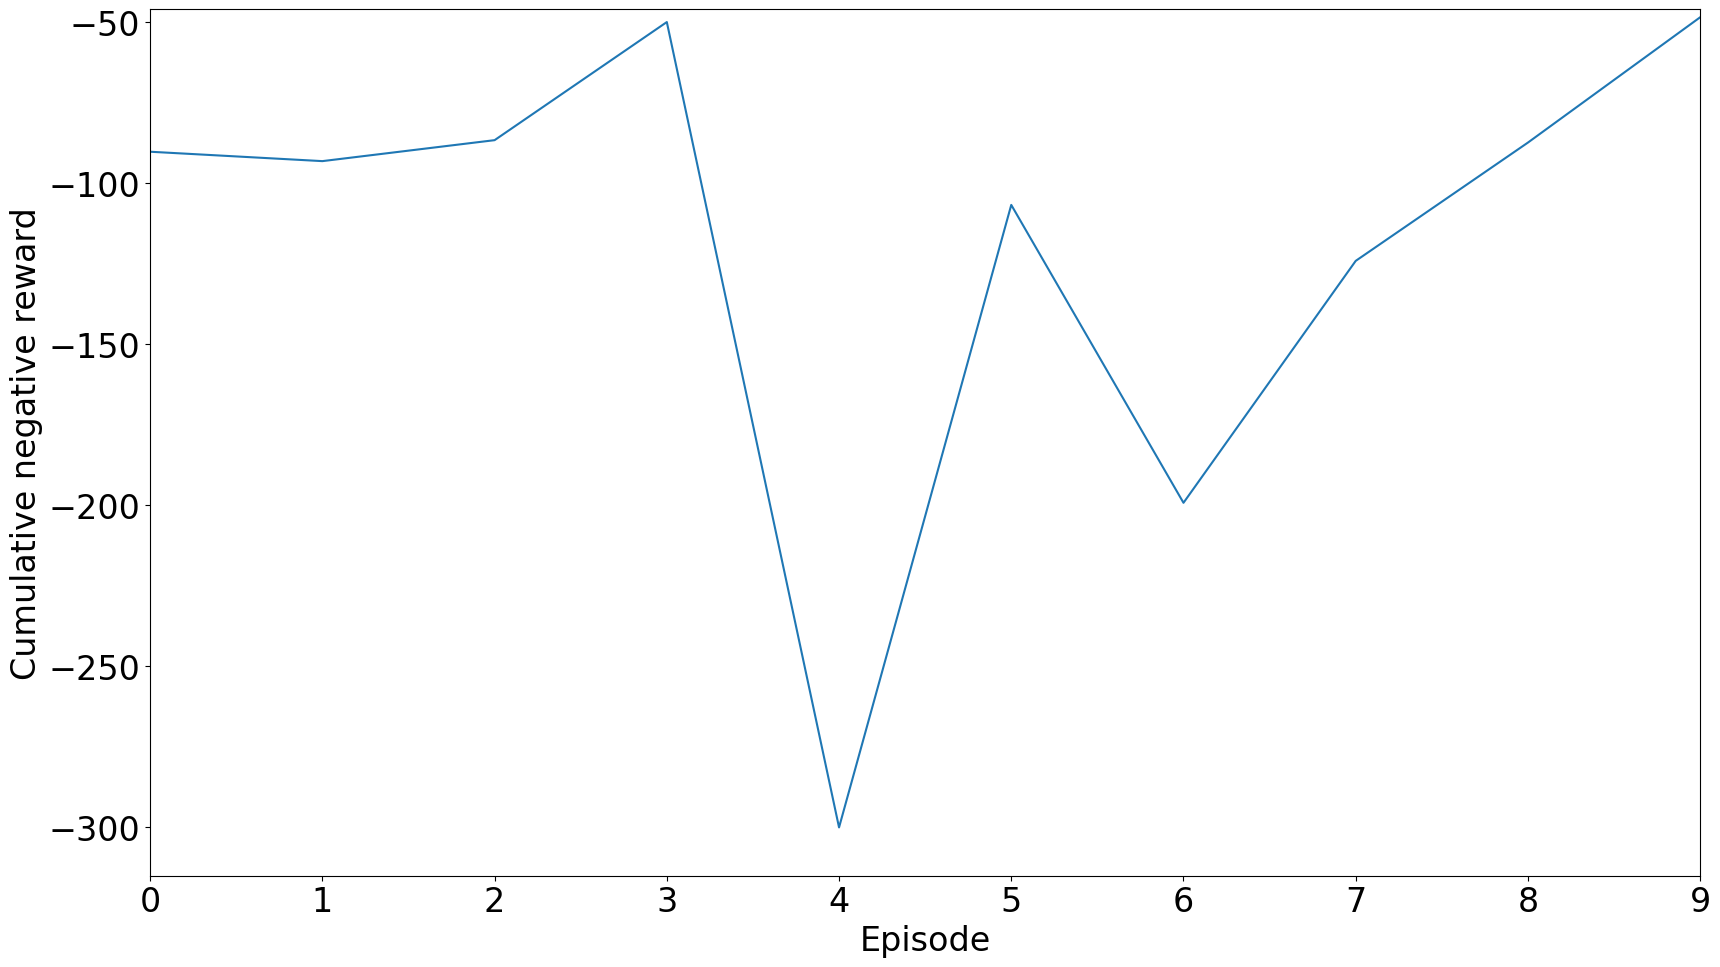

In [167]:
# Traffic congestion, lower is better
visualization.save_data_and_plot(data=simulation.reward_store, filename='reward', xlabel='Episode', ylabel='Cumulative negative reward')  

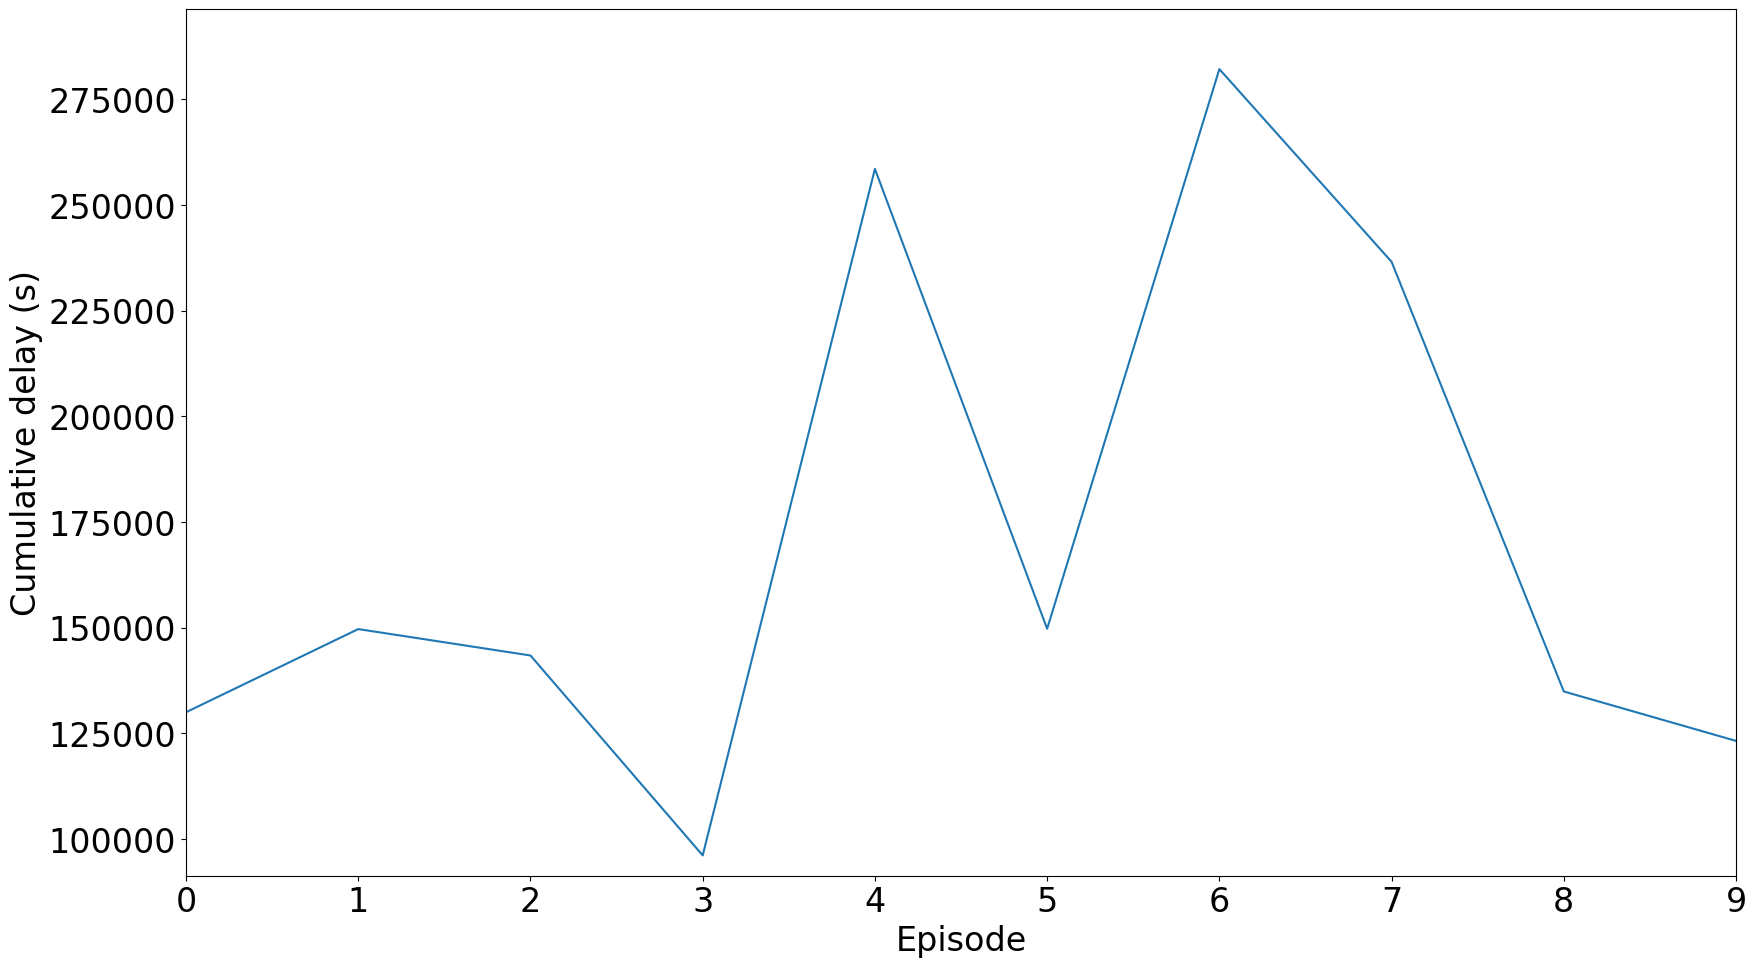

In [168]:
# Time the vehicles have to wait
visualization.save_data_and_plot(data=simulation.cumulative_wait_store, filename='delay', xlabel='Episode', ylabel='Cumulative delay (s)')

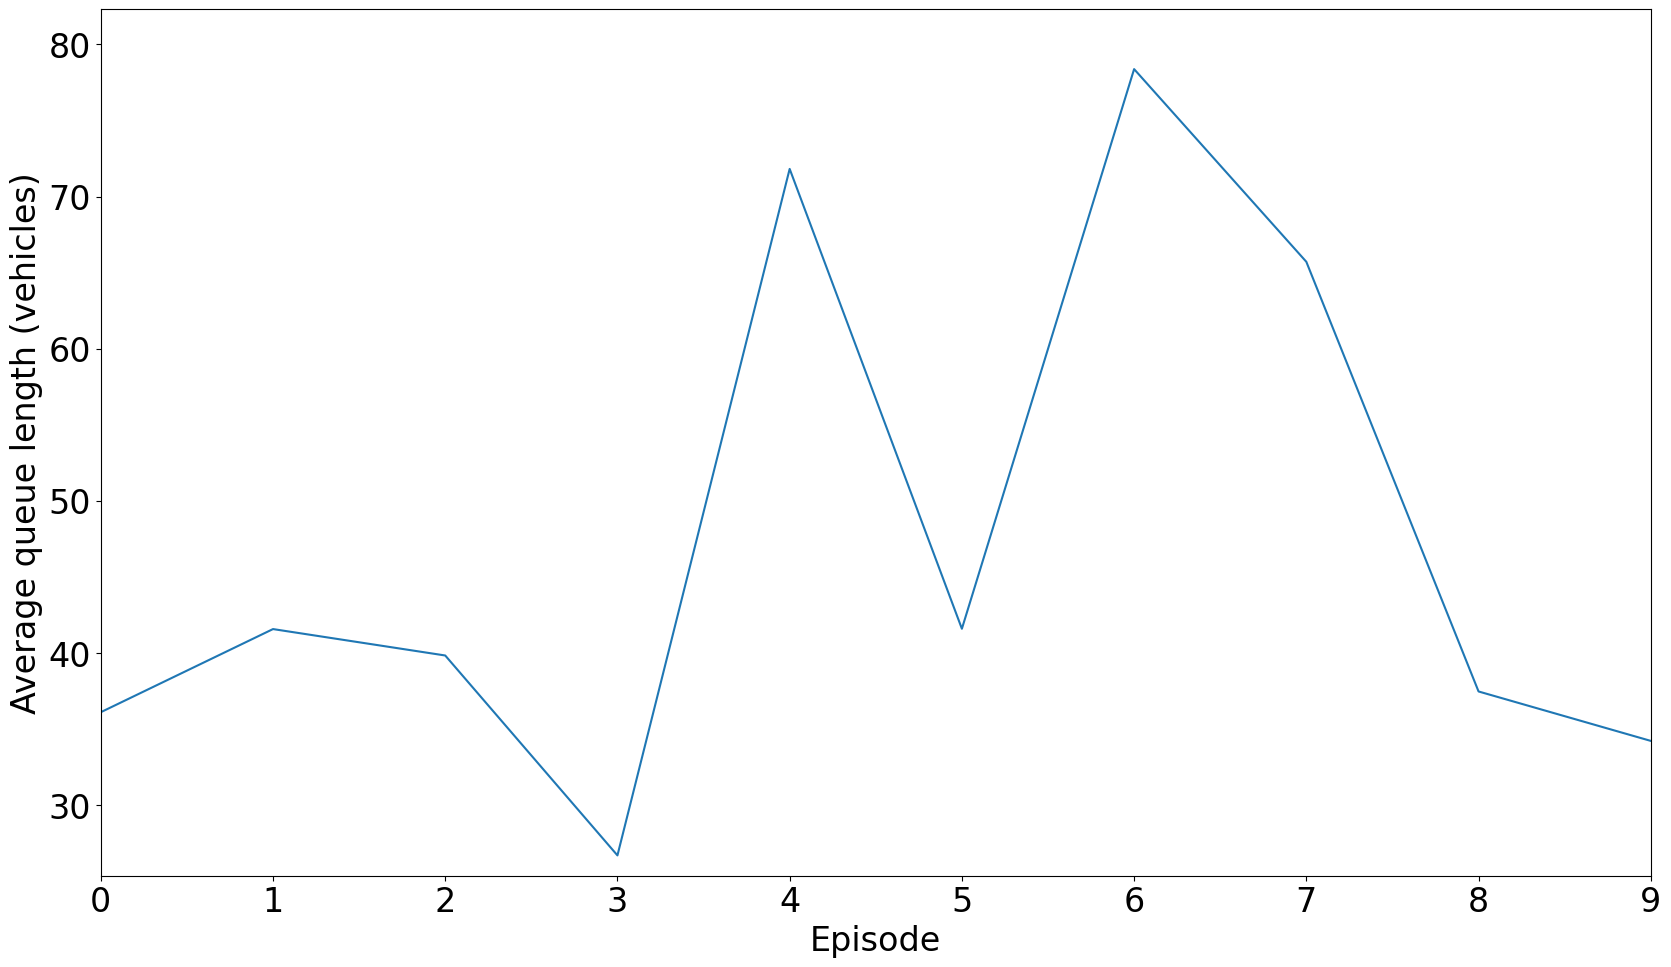

In [169]:
visualization.save_data_and_plot(data=simulation.avg_queue_length_store, filename='queue', xlabel='Episode', ylabel='Average queue length (vehicles)')

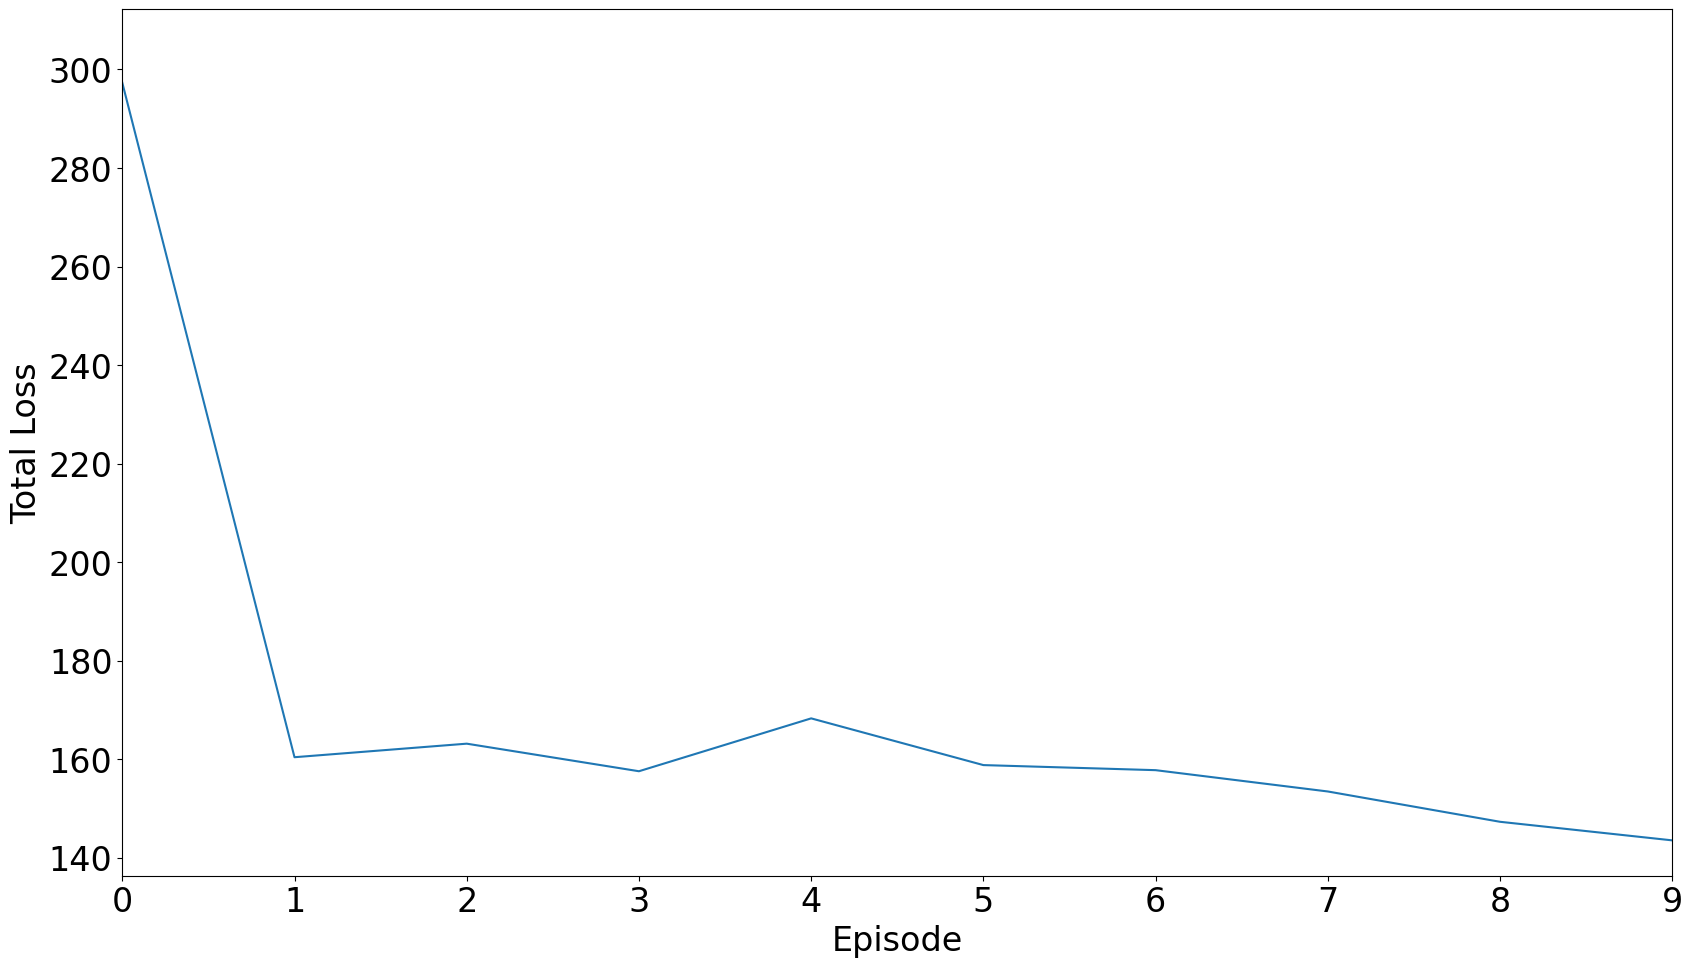

In [170]:
visualization.save_data_and_plot(data=trainer.loss_store, filename='Loss', xlabel='Episode', ylabel='Total Loss')

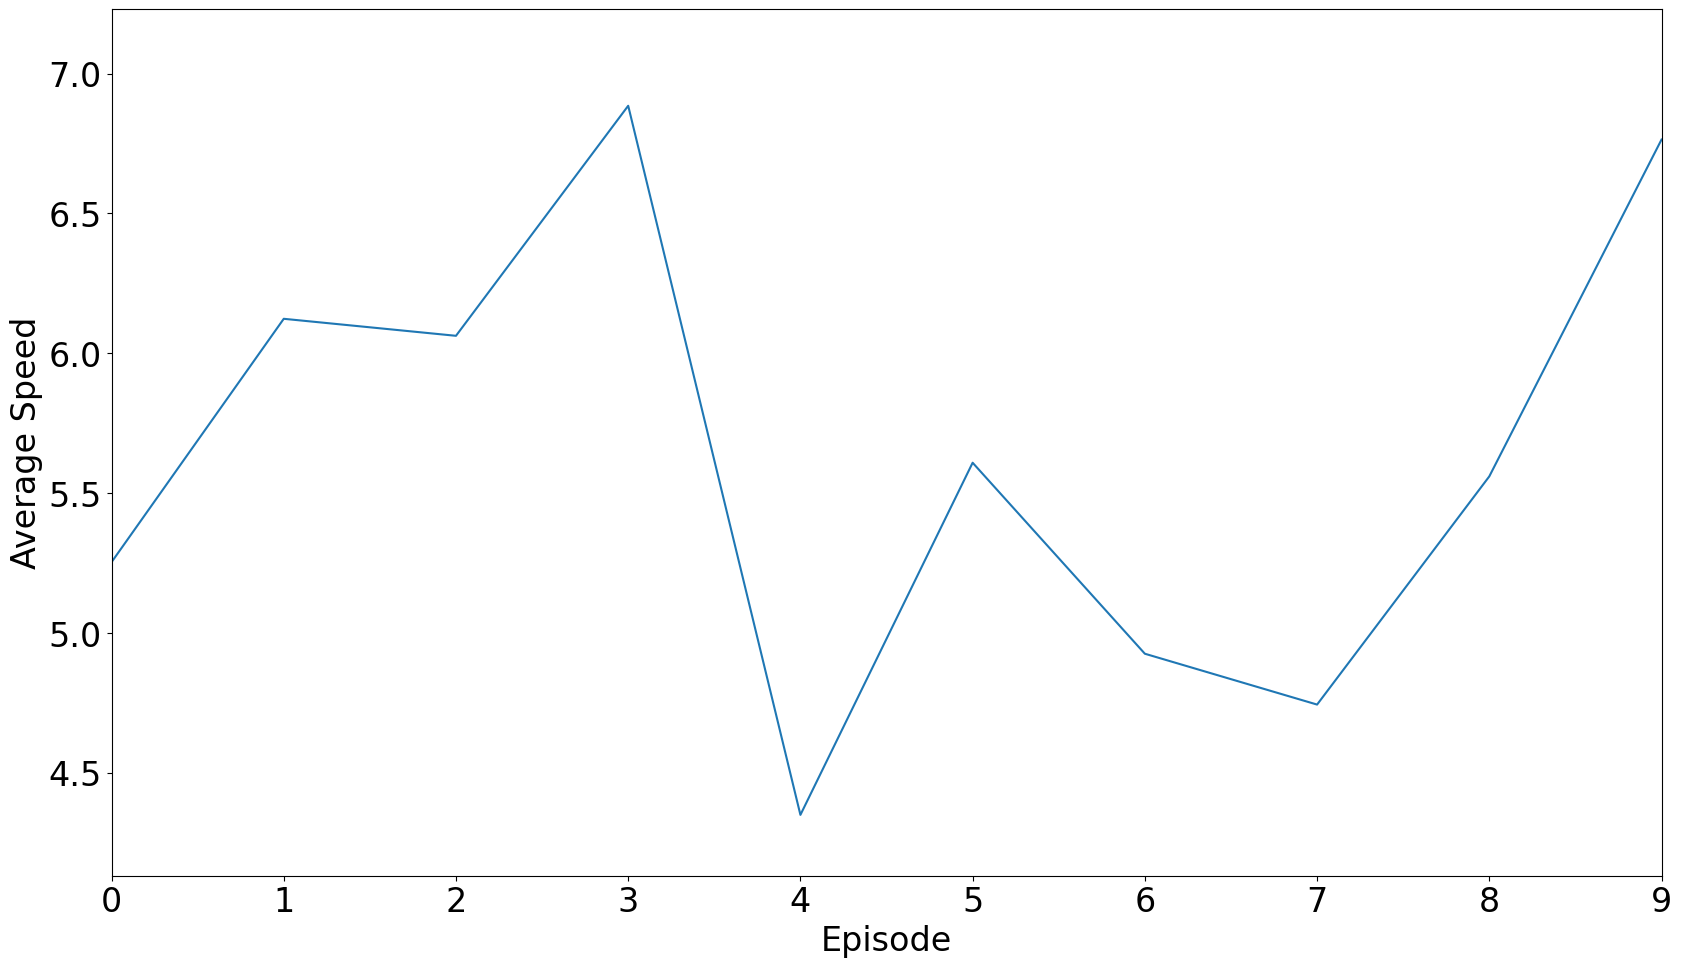

In [171]:
# The speed of the vehicles, higher is better
visualization.save_data_and_plot(data=simulation.speed_store, filename='Speed', xlabel='Episode', ylabel='Average Speed')

- Categorical 
- Action definition 
- Phase Gate, FRAP 
- Memory Palace for Change-Stay
- Run 3 * 4 model
- not too difference with dones